# Adjoint optimization of a photonic crystal

In this notebook, we will use inverse design to optimize coupling from a silicon waveguide to a photonic crystal slab.

We'll first set up a very simple photonic crystal in a silicon slab.

Then, we'll maximize the transmitted flux through the crystal at a frequency just above the bandgap. 

Our degrees of freedom will be the center of the holes cut in the photonic crystal, but modifying this example, one can easily adjust the radius of each hole as well as an extra design parameter.

<!-- <img src="img/adjoint_9.png" width=400 alt="Schematic of the waveguide division multiplexer"> -->

If you are unfamiliar with inverse design, we also recommend our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/).


In [74]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

# we'll use autograd for automatic differentiation, so derivative-traced numpy operations will use autograd.numpy
import autograd.numpy as anp
import autograd

## Setup

First, we will set up some of our global parameters for the study.

The structure will consist of a rectangular lattice of air holes in a silicon slab.

In [90]:
nm = 1e-3

wvl0 = 1550 * nm
a = 400 * nm

num_freqs = 151

wvl_min, wvl_max = (1400 * nm, 1700 * nm)
freq_min = td.C_0 / wvl_max
freq_max = td.C_0 / wvl_min

freqs = np.linspace(freq_min, freq_max, num_freqs)
freq0 = td.C_0 / wvl0

fwidth = freq0 / 10
run_time = 300 / fwidth

sqrt3_div2 = np.sqrt(3) / 2.0

In [91]:
# silicon material (for slab)
n_si = 3.48
si = td.Medium(permittivity=n_si**2)
air = td.Medium()

In [92]:
# radius of holes
r0 = 90 * nm

# when we optimize, the radius will vary between these two values
# for now we just constrain all radius to r0, but change these values to add more degrees of freedom
r_range = rmin, rmax = (r0, r0)
rmid = r0

# how much centers can move from the center
drmax = a/4

In [93]:
# number of holes in x and y
N_rows = 15
N_cols = 19
N_cols_static = 5

# total length of the PhC region
Lx_phc = N_cols * a + a/2
Ly_phc = N_rows * sqrt3_div2 * a + a/2

# buffer on each side of the design region
buffer = 1.0 * wvl0

# thickness of slab
t_slab = 220 * nm

# waveguide width
w_wg = 1.3 * a

In [94]:
# size of simulation
Lx = Lx_phc + 2 * buffer
Ly = Ly_phc + 2 * buffer
Lz = t_slab + 2 * buffer

In [95]:
# define grid resolution
steps_per_unit_cell = 14
dx = a / steps_per_unit_cell
dy = a * sqrt3_div2 / steps_per_unit_cell

grid_spec = td.GridSpec(
    grid_x = td.UniformGrid(dl=dx),
    grid_y = td.UniformGrid(dl=dy),
    grid_z = td.AutoGrid(min_steps_per_wvl=steps_per_unit_cell)
)

In [96]:
def make_holes(params) -> td.Structure:
    """Convenience function to make the phc holes given the design parameters."""

    hole_spacing_x = a
    hole_spacing_y = a * sqrt3_div2
    
    x_slab_length, y_slab_length = hole_spacing_x * (N_cols + 0.5), hole_spacing_y * N_rows
    start_x, start_y = (
        - x_slab_length / 2 + hole_spacing_x / 2,
        - y_slab_length / 2 + hole_spacing_y / 2,
    )

    cylinders = []

    for i in range(0, N_cols):
        for j in range(0, N_rows):

            # depending on distance from central column, hole is either static
            i_dist = abs(i - N_cols // 2)
            if i_dist < ((N_cols_static) / 2):
                radius = rmid
                dx = dy = 0

            # or optimizable
            else:
                radius = params[0,i,j]
                dx = params[1,i,j]
                dy = params[2,i,j]

            x0 = dx + start_x + (i + (j % 2) * 0.5) * hole_spacing_x
            y0 = dy + start_y + j * hole_spacing_y
            if j != N_rows // 2:
                c = td.Cylinder(
                    axis=2,
                    radius=radius,
                    center=(x0, y0, 0),
                    length=td.inf,
                )
                cylinders.append(c)

    # use GeometryGroup since all same medium, for performance
    structure = td.Structure(
        geometry=td.GeometryGroup(geometries=cylinders),
        medium=air,
        background_medium=si, # note: we need this for correct gradients when embedded in slab
    )

    return structure

In [97]:
source = td.ModeSource(
    center=(-Lx/2 + wvl0/10, 0, 0),
    size=(0, Ly_phc/2.0, td.inf),
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth
    ),
    direction="+",
)

In [98]:
# these monitors are just for plotting the broadband flux response, not optimizing
# FluxMonitor is not supported in autograd

slab = td.Structure(
    geometry=td.Box(
        center=(0,0,0),
        size=(Lx_phc, Ly_phc, t_slab),
    ),
    medium=si,
)

waveguide = td.Structure(
    geometry=td.Box(
        center=(0,0,0),
        size=(td.inf, w_wg, t_slab),
    ),
    medium=si,
)


mnt_flux = td.FluxMonitor(
    center=(-source.center[0], 0, 0),
    size=(0, td.inf, td.inf),
    freqs=freqs,
    name='flux',
)

# this monitor is for visualizing field patterns only
mnt_field = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name='field',
)

# These monitors are used for the optimization
# FieldMonitor.flux is used because FluxMonitor not supported in autograd

mnt_field_flux = td.FieldMonitor(
    center=(+Lx_phc/2 - a, 0, 0),
    size=(0, td.inf, td.inf),
    freqs=[freq0],
    name='flux',
)


In [99]:
def make_sim(params, optimization_mode: bool = False) -> td.Simulation:
    """Function to generate a simulation with different monitors depending on whether optimizing."""
    
    # create the holes
    holes = make_holes(params)

    # decide which monitors to include
    if not optimization_mode:
        monitors = [mnt_flux, mnt_field]
    else:
        monitors = [mnt_field_flux]

    return td.Simulation(
        center=[0, 0, 0],
        size=[Lx, Ly, Lz],
        grid_spec=grid_spec,
        structures=[slab, waveguide, holes],
        sources=[source],
        monitors=monitors,
        run_time=run_time,
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=True),
        symmetry=(0,-1,1),
    )

Let's make a simulation with the starting parameters, and one with just the waveguide, for normalization.

In [100]:
params0 = rmid * np.ones((3, N_cols, N_rows))
params0[1:] = 0.0

sim0 = make_sim(params0, optimization_mode=False)

sim_wg = sim0.updated_copy(structures=[waveguide])

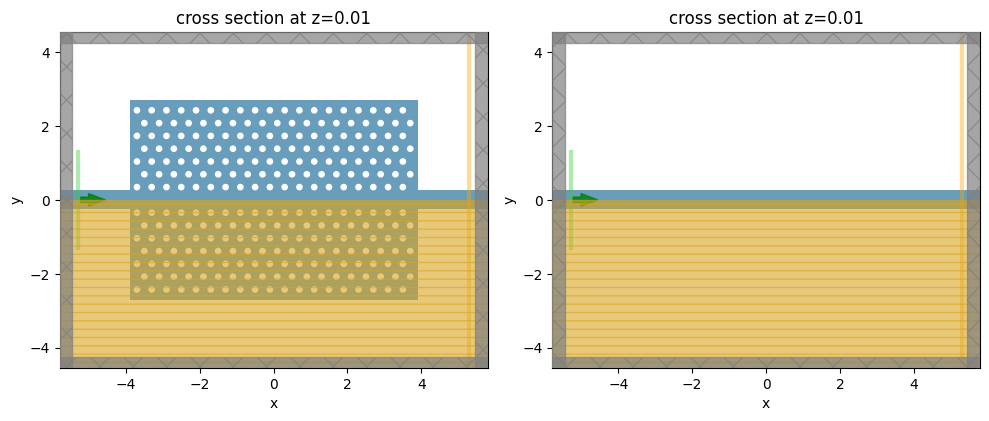

In [101]:
_, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
_ = sim0.plot(z=0.01, ax=ax1)
_ = sim_wg.plot(z=0.01, ax=ax2)

plt.show()

Next, we can run these two simulations to inspect the fields and compute some normalization.

In [102]:

sim_data0 = web.Job(simulation=sim0, task_name='initial PhC').run()
sim_data_wg = web.Job(simulation=sim_wg, task_name='initial PhC norm').run()

10:42:11 CET Created task 'initial PhC' with task_id                            
             'fdve-bdfaf645-4a96-46b5-aa4d-8d2277a86497' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=48800;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bdfaf645-4a96-46b5-aa4d-8d2277a86497\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=116247;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bdfaf645-4a96-46b5-aa4d-8d2277a86497\taskId]8;;\]8;id=48800;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bdfaf645-4a96-46b5-aa4d-8d2277a86497\=]8;;\]8;id=213968;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bdfaf645-4a96-46b5-aa4d-8d2277a86497\fdve]8;;\]8;id=48800;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bdfaf645-4a96-46b5-aa4d-8d2277a86497\-bdfaf645-4a9]8;;\
             ]8;id=48800;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bdfaf645-4a96-46b5-aa4d-8d2277a86497\6-46b5-aa4d-8d2277a86497']8;;\.

Output()

10:42:15 CET status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

10:42:21 CET status = preprocess

10:42:23 CET Maximum FlexCredit cost: 0.251. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

10:42:24 CET running solver

Output()

10:43:11 CET early shutoff detected at 68%, exiting.

             status = postprocess

Output()

10:43:14 CET status = success

             View simulation result at                                          
             ]8;id=931377;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bdfaf645-4a96-46b5-aa4d-8d2277a86497\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=180642;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bdfaf645-4a96-46b5-aa4d-8d2277a86497\taskId]8;;\]8;id=931377;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bdfaf645-4a96-46b5-aa4d-8d2277a86497\=]8;;\]8;id=61323;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bdfaf645-4a96-46b5-aa4d-8d2277a86497\fdve]8;;\]8;id=931377;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bdfaf645-4a96-46b5-aa4d-8d2277a86497\-bdfaf645-4a9]8;;\
             ]8;id=931377;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bdfaf645-4a96-46b5-aa4d-8d2277a86497\6-46b5-aa4d-8d2277a86497']8;;\.

Output()

10:43:19 CET loading simulation from simulation_data.hdf5

             Created task 'initial PhC norm' with task_id                       
             'fdve-a81df8f5-9b6e-4820-8913-aed3c39060dd' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=661952;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81df8f5-9b6e-4820-8913-aed3c39060dd\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=183652;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81df8f5-9b6e-4820-8913-aed3c39060dd\taskId]8;;\]8;id=661952;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81df8f5-9b6e-4820-8913-aed3c39060dd\=]8;;\]8;id=28770;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81df8f5-9b6e-4820-8913-aed3c39060dd\fdve]8;;\]8;id=661952;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81df8f5-9b6e-4820-8913-aed3c39060dd\-a81df8f5-9b6]8;;\
             ]8;id=661952;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81df8f5-9b6e-4820-8913-aed3c39060dd\e-4820-8913-aed3c39060dd']8;;\.

Output()

10:43:22 CET status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

10:43:28 CET status = preprocess

10:43:30 CET Maximum FlexCredit cost: 0.251. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

10:43:37 CET early shutoff detected at 4%, exiting.

             status = postprocess

Output()

10:43:38 CET status = success

             View simulation result at                                          
             ]8;id=967791;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81df8f5-9b6e-4820-8913-aed3c39060dd\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=603877;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81df8f5-9b6e-4820-8913-aed3c39060dd\taskId]8;;\]8;id=967791;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81df8f5-9b6e-4820-8913-aed3c39060dd\=]8;;\]8;id=351355;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81df8f5-9b6e-4820-8913-aed3c39060dd\fdve]8;;\]8;id=967791;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81df8f5-9b6e-4820-8913-aed3c39060dd\-a81df8f5-9b6]8;;\
             ]8;id=967791;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81df8f5-9b6e-4820-8913-aed3c39060dd\e-4820-8913-aed3c39060dd']8;;\.

Output()

10:43:42 CET loading simulation from simulation_data.hdf5

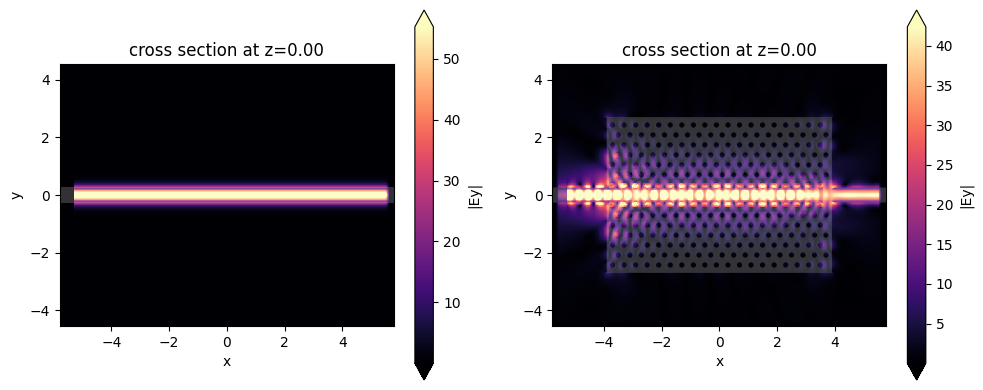

In [103]:
_, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
_ = sim_data_wg.plot_field("field", field_name="Ey", val="abs", ax=ax1)
_ = sim_data0.plot_field("field", field_name="Ey", val="abs", ax=ax2)

plt.show()

Let's visualize the transmission. We can clearly see the bandgap, but above the bandgap, the transmission is not great. We will optimize transmitted flux at the orange line. 

> Note: one can also do this with `ModeMonitor` and include a broadband objective.

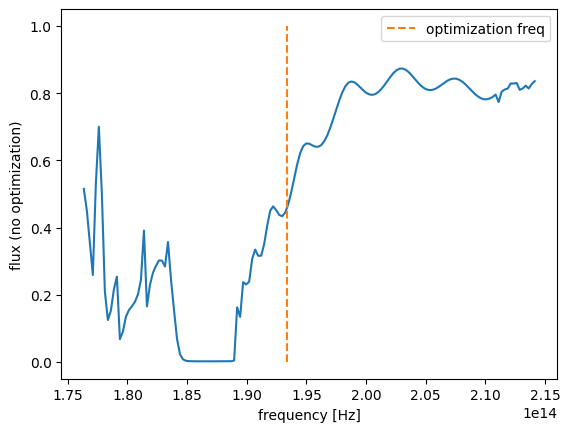

In [104]:
flux_wg = abs(sim_data_wg['flux'].flux)
flux0 = abs(sim_data0['flux'].flux) / flux_wg
flux0.plot(x='f')
plt.ylabel('flux (no optimization)')
plt.plot([freq0, freq0], [0,1], linestyle='--', label='optimization freq')
plt.legend()
plt.show()

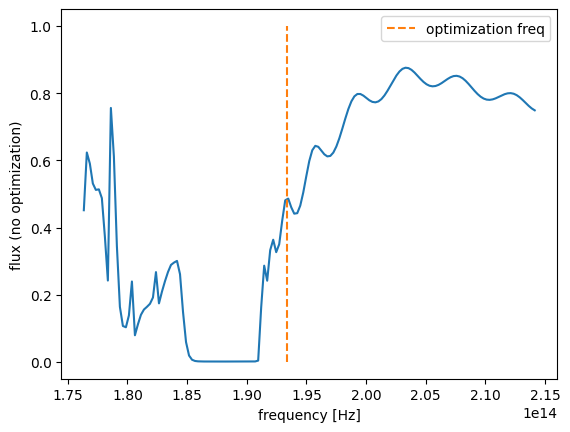

In [16]:
flux_wg = abs(sim_data_wg['flux'].flux)
flux0 = abs(sim_data0['flux'].flux) / flux_wg
flux0.plot(x='f')
plt.ylabel('flux (no optimization)')
plt.plot([freq0, freq0], [0,1], linestyle='--', label='optimization freq')
plt.legend()
plt.show()

In [105]:
flux0_freq0 = flux_wg.interp(f=freq0).item()
print(flux0_freq0)

1.0000138821140412


The normalization flux is about 1, which is as expected as our `ModeSource` takes this into account.

## Optimization

Next, we will define our inverse design problem. We'll adjust the centers and radii (if desired) to maximize flux at `freq0`, normalized by our straight waveguide transmission.

In [106]:
def objective(params: anp.ndarray) -> float:
    """Maximize flux in -y, minimize flux in +x."""
    
    sim = make_sim(params, optimization_mode=True)
    sim_data = web.run(sim, task_name='phc_adjoint', verbose=False)
    
    flux_measure_freq0 = anp.sum(anp.abs(sim_data['flux'].flux.data))

    return flux_measure_freq0 / flux_wg.interp(f=freq0).item()

As always, we can use one line of `autograd` code to get a function that gives the value and gradient of our objective when passed some parameters.

In [107]:
val_grad = autograd.value_and_grad(objective)

And then we can use this funtion in our gradient-ascent optimizer using `optax`.

We first set up the optimizer parameters.

In [108]:
import optax
from autograd.tracer import getval

# hyperparameters
num_steps = 10
learning_rate = a/40
# note: the step size needs to be quite low because of the direct modification of geometric parameter

# initialize adam optimizer with starting parameters
params = np.array(params0).copy()
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
objective_history = []
param_history = [params]
data_history = []

And then run the optimization in a for loop (note: to continue optimization, you can always re-run this cell assuming `params` is set to the last parameters from your previous run.

In [109]:
%%time

for i in range(num_steps):

    print(f"step = {i + 1}")

    # compute gradient and current objective funciton value
    value, gradient = val_grad(params)

    gradient = np.array(gradient)

    # outputs
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the optimizer based on gradient
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # it is important using optax to convert the parameters back to numpy arrays to feed back to our gradient
    params = np.array(params)
    params[0] = anp.clip(params[0], rmin, rmax)
    params[1:] = anp.clip(params[1:], -drmax, drmax)

    # save history
    objective_history.append(value)
    param_history.append(params)

step = 1
	J = 4.9913e-01
	grad_norm = 1.3225e+01
step = 2
	J = 7.1040e-01
	grad_norm = 7.6651e+00
step = 3
	J = 7.9986e-01
	grad_norm = 5.9899e+00
step = 4
	J = 8.3010e-01
	grad_norm = 6.2971e+00
step = 5
	J = 8.4537e-01
	grad_norm = 7.5235e+00
step = 6
	J = 8.8144e-01
	grad_norm = 5.2108e+00
step = 7
	J = 8.9780e-01
	grad_norm = 5.2837e+00
step = 8
	J = 9.0196e-01
	grad_norm = 8.0595e+00
step = 9
	J = 9.3306e-01
	grad_norm = 2.9615e+00
step = 10
	J = 9.4724e-01
	grad_norm = 2.0609e+00
CPU times: user 14min 39s, sys: 8.75 s, total: 14min 48s
Wall time: 24min 23s


## Results

Let's inspect the results of the optimization.

The objective function increased steadily.

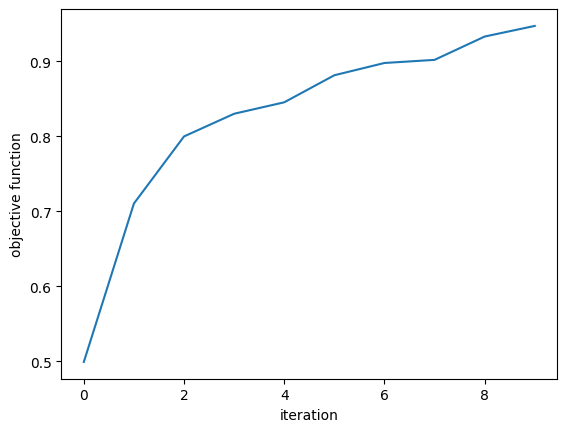

In [110]:
plt.plot(objective_history)
plt.xlabel('iteration')
plt.ylabel('objective function')
plt.show()

We can grab the last simulation from the parameter history and visualize the fields and flux values over the full spectrum.

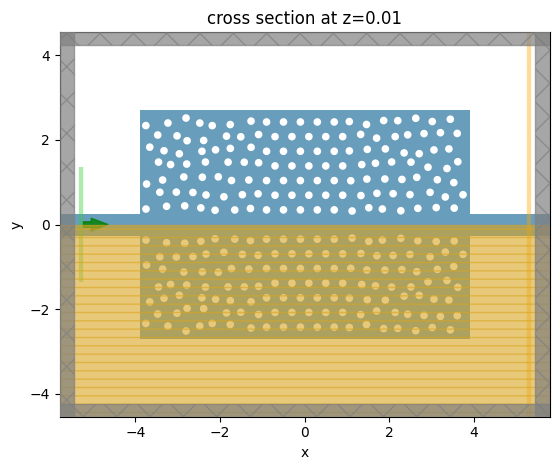

In [111]:
params_final = param_history[-1]

sim_final = make_sim(params_final, optimization_mode=False)
_ = sim_final.plot(z=0.01)
plt.show()

In [112]:
sim_data_final = web.run(sim_final, task_name='phc')

11:11:03 CET Created task 'phc' with task_id                                    
             'fdve-a6cff05a-90ae-46b1-af30-16656cb2ce1f' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6cff05a-90ae-46b1-af30-16656cb2ce1f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=426017;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6cff05a-90ae-46b1-af30-16656cb2ce1f\taskId]8;;\]8;id=714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6cff05a-90ae-46b1-af30-16656cb2ce1f\=]8;;\]8;id=969597;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6cff05a-90ae-46b1-af30-16656cb2ce1f\fdve]8;;\]8;id=714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6cff05a-90ae-46b1-af30-16656cb2ce1f\-a6cff05a-90a]8;;\
             ]8;id=714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6cff05a-90ae-46b1-af30-16656cb2ce1f\e-46b1-af30-16656cb2ce1f']8;;\.

Output()

11:11:06 CET status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

11:11:11 CET status = preprocess

11:11:13 CET Maximum FlexCredit cost: 0.251. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

11:11:14 CET running solver

Output()

11:11:34 CET early shutoff detected at 28%, exiting.

11:11:35 CET status = postprocess

Output()

11:11:36 CET status = success

             View simulation result at                                          
             ]8;id=777002;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6cff05a-90ae-46b1-af30-16656cb2ce1f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=616446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6cff05a-90ae-46b1-af30-16656cb2ce1f\taskId]8;;\]8;id=777002;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6cff05a-90ae-46b1-af30-16656cb2ce1f\=]8;;\]8;id=511606;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6cff05a-90ae-46b1-af30-16656cb2ce1f\fdve]8;;\]8;id=777002;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6cff05a-90ae-46b1-af30-16656cb2ce1f\-a6cff05a-90a]8;;\
             ]8;id=777002;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6cff05a-90ae-46b1-af30-16656cb2ce1f\e-46b1-af30-16656cb2ce1f']8;;\.

Output()

11:11:41 CET loading simulation from simulation_data.hdf5

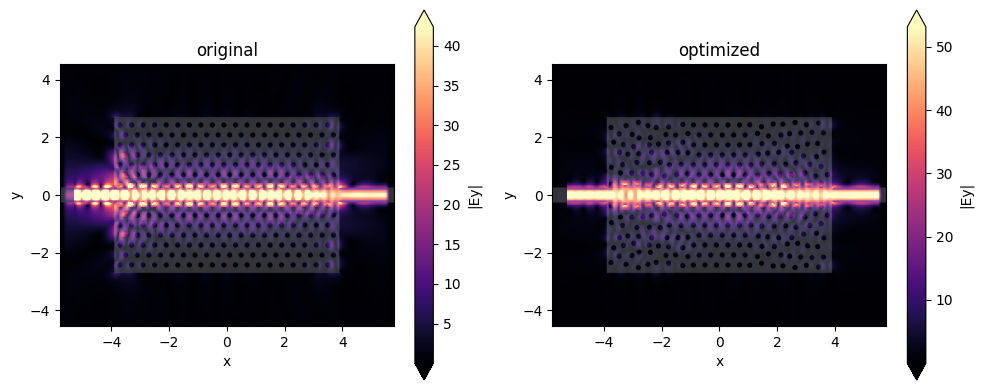

In [113]:
_, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, figsize=(10,4))
# vmax = 30

ax1 = sim_data0.plot_field("field", field_name="Ey", val="abs", ax=ax1)
ax2 = sim_data_final.plot_field("field", field_name="Ey", val="abs", ax=ax2)
ax1.set_title('original')
ax2.set_title('optimized')
plt.show()

The optimized fields look much smoother, with far less reflection from the input ports.

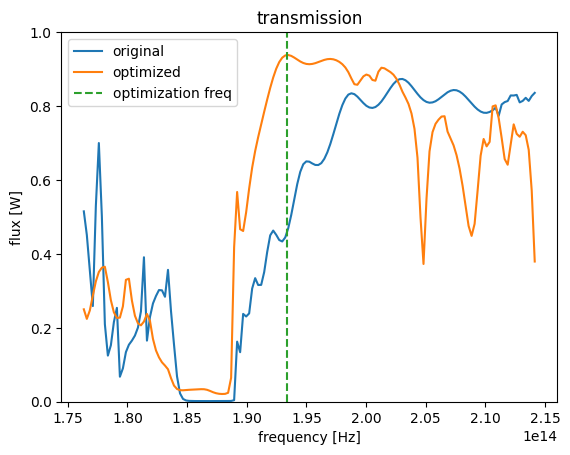

In [114]:
flux_final = abs(sim_data_final['flux'].flux)

flux0.plot(x='f', label='original')
flux_final.plot(x='f', label='optimized')

plt.ylim([0,1])
plt.title('transmission')
plt.plot([freq0, freq0], [0,1], linestyle='--', label='optimization freq')

plt.legend()
plt.show()

And the new transmission (orange) is far higher above the bandgap, meaning that this new device is coupling light much better from the input waveguide!